# FEM con codigo abierto
FEniCs utiliza la formulacion variacional o formulacion debil.

## Analizando la ecuacion de Poisson
\begin{equation}\large
\begin{split}
    -\Delta u &= F \qquad \text{en} \quad \Omega \\
    u &=  u_0 \qquad \text{en} \quad \partial\Omega \\
\end{split}    
\end{equation}

### Laplaciano
Operador diferencial que resulta de aplicar la divergencia al gradiente 

* En coordinadas cartesianas
\begin{equation}\large
\Delta f=\frac{\partial ^{2}f}{\partial x^{2}}+ \frac {\partial ^{2}f}{\partial y^{2}}
\end{equation}

* En coordinadas polares
\begin{aligned}\large
\Delta f&= \frac{1}{r}\frac {\partial }{\partial r} \left(r{\frac {\partial f}{\partial r}}\right)+{\frac {1}{r^{2}}}{\frac {\partial ^{2}f}{\partial \theta ^{2}}}\\
&={\frac {\partial ^{2}f}{\partial r^{2}}}+{\frac {1}{r}}{\frac {\partial f}{\partial r}}+{\frac {1}{r^{2}}}{\frac {\partial ^{2}f}{\partial \theta ^{2}}},
\end{aligned}

* Relacion con otros operadores
\begin{aligned}\large
\Delta f &= \nabla^2f \\
         &= \nabla \cdot \nabla f \\
         &= \mathrm{div}(\mathbf{grad}(f))
\end{aligned}



## Ejercicio 1
Sea una membrana de Mylar de 30 cm de diametro y 10 mil de espesor encastrada en los bordes. 
* Calcular la defleccion de la membrana al aplicar una presion de 10 N
* Evaluar la maxima defleccion usando elementos lineales y cuadraticos. Calcular el error relaitvo con la teoria.
* Calcular 10 primeros modos de vibracion.

In [1]:
# Importar packages
import numpy as np
from dolfin import *
from mf.geometry import CircularMesh    # Varias geometrias simples...

In [2]:
# Material properties
mesh_name = 'circle.msh'
R    = 0.30
rhov = 1380                 # Mylar density
e    = 10 * 25.4e-6
rho  = rhov*e

h = 0.01
plot_info = 'plot off' # not working on jupyter

fmesh, mf_boundary, tag_bords = CircularMesh('meshes/', mesh_name, R, h, plot_info)



Info    : Meshing 1D...
Info    : [  0%] Meshing curve 10 (Circle)
Info    : [ 30%] Meshing curve 11 (Circle)
Info    : [ 50%] Meshing curve 12 (Circle)
Info    : [ 80%] Meshing curve 13 (Circle)
Info    : Done meshing 1D (Wall 0.000570429s, CPU 0.000753s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0958807s, CPU 0.096071s)
Info    : 3529 nodes 7059 elements
Existing file, wanna replace-it? [y/n/c]: y
Info    : Writing 'meshes/circle.msh'...
Overwriting existing fileInfo    : Done writing 'meshes/circle.msh'

Reading 1d line data into dolfin mvc
Constructing MeshFunction from MeshValueCollection


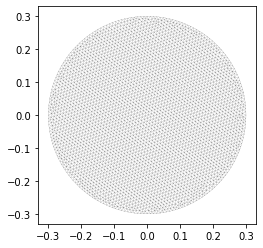

In [3]:
# La funcion plot es nativa de fenics!. No confuncdir con plt.plot de matplolib
plot(fmesh, lw = .1, color='k')

In [4]:
element = FiniteElement("Lagrange", triangle,  2)   # Crear el elemento finito
Vh = FunctionSpace(fmesh, element)                  # Crear el espacio de funciones lineales (1)

def boundary(x, on_boundary):
    return on_boundary                              # Obtener los elementos de la frontera

#bc = DirichletBC(Vh, Constant(0.), boundary)        # Aplicar BC al problema
bc = DirichletBC(Vh, Constant(0.), mf_boundary, tag_bords)        # Aplicar BC al problema

dx = Measure("dx", domain= fmesh)                   # Omega

In [5]:
# Define  variational problem
u_h = TrialFunction(Vh)  # Establecer la funcion Trial
v_h = TestFunction(Vh)   # Establecer la funcion Test

## Ecuacion de Poisson y defleccion de una membrana
\begin{equation}\large
\begin{split}
    -c^2\Delta u &= F \qquad \text{en} \quad \Omega \\
    u &=  u_0 \qquad \text{en} \quad \partial\Omega \\
\end{split}    
\end{equation}

## Formulacion variacional
\begin{equation}\large\label{eq:poison_var2}
c^2\int_{ \Omega}  \nabla u \cdot \nabla v  \text{d}x - \underbrace{\int_{\partial \Omega}\frac{\partial u}{\partial n} v \text{ds}}_{\text{=0}}= \int_{\Omega} Pv \text{d}x
\end{equation}
\begin{equation}\large
    \underbrace{c^2\int_{\Omega}  \nabla u_h \cdot \nabla v_h  \text{d}x}_{a(u_h,v_h)} = \underbrace{\int_{\Omega} Pv_h\text{d}x}_{L(v_h)}
\end{equation}


In [6]:
P = 10 #Pa
T = 1000 #N/m2
c = sqrt(T/rho)

L = P*v_h*dx
a = c**2 * dot(grad(u_h), grad(v_h))*dx 

w_h = Function(Vh)

#%% Compute solution
solve(a == L, w_h, bc)


Solving linear variational problem.


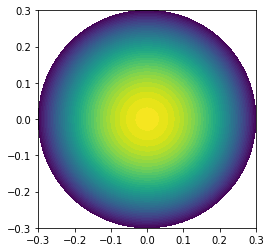

In [7]:
plot(w_h)

In [8]:
# Maxima defleccion
u_max = w_h([0,0])
print(u_max)

7.885280598090644e-05


In [9]:
# Teoria 
wmax =  rho*P/T * R**2/4
print(wmax)
def error_rel(val_num, val_teo):
    return print(np.abs(val_teo - val_num)/(val_teo)*100)

error_rel(u_max, wmax)

7.8867e-05
0.017997412217480187


## Ecuacion de Poisson y modos de una membrana
\begin{equation}\large
\begin{split}
    -c^2\Delta \phi &= -\lambda \phi \qquad \text{en} \quad \Omega \\
    \phi &=  \phi_0 \qquad \text{en} \quad \partial\Omega \\
\end{split}    
\end{equation}

## Formulacion variacional
\begin{equation}\large\label{eq:helmholtz_modes}
        \int_{ \Omega} \nabla \phi \cdot \nabla v  \text{d}x 
        +\int_{\partial \Omega}\frac{\partial \phi}{\partial n} v\text{ds}
        = \omega^2 \int_{\Omega} \frac{1}{c^2}\phi v\text{d}x
\end{equation}

\begin{equation}\large
        \underbrace{\int_{ V_h}  \nabla \phi_h \cdot \nabla v_h \text{d}x}_{\text{K}} 
        = \omega^2 \underbrace{\int_{V_h}\frac{1}{c^2}\phi_h v_h\text{d}x}_{\text{M}}
\end{equation}



In [ ]:
# Eigenvalue problem (poner bien)
phi_h = Function(Vh)
v_h   = Function(Vh)

K = T*inner(grad(phi_h), grad(v_h))*dx 
M = rho*inner(phi_h,v_h)*dx
    
M_ = PETScMatrix()
assemble(M, tensor = M_)

# Assemble matrices
K_ = PETScMatrix()
assemble(K, tensor = K_)

# object is a list or not 
if isinstance(bc, list): 
    bc  = bc
else:        
    bc  = [bc]

for bcs in bc:
    bcs.apply(K_)
    bcs.zero(M_)   

Calling FFC just-in-time (JIT) compiler, this may take some time.
